# 파일 설명
- 한국인 얼굴 감정 인식을 위한 ViT(Vision Transformer) 모델 전이학습 코드

- 이 코드는 COCO 형식으로 제공되는 한국인 얼굴 감정 데이터셋을 사용하여
ViT 모델의 분류기만 전이학습합니다.
  - ViT 백본은 고정하고 분류 헤드만 학습하여 빠르고 효율적인 학습을 수행합니다.
  - COCO 형식의 바운딩 박스 정보를 활용하여 얼굴 영역을 자동으로 크롭하고,
  - 7개 감정 클래스(angry, disgust, fear, happy, neutral, sad, surprise)로
분류하는 모델을 학습합니다.

## 코드 구성
1. 라이브러리 임포트 및 설정
2. 데이터셋 클래스 (COCODataset)
3. 데이터셋 경로 설정 함수
4. 데이터 시각화 함수
5. 분류기 학습 함수
6. 메인 함수


# 1. 라이브러리 임포트 및 설정

In [5]:
# Google Drive를 Colab 환경에 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
id = '1D5yAVPgDcNdZrFzftgLnmOaEd-Swy-GF'
!gdown {id} -O /content/roboflow.zip
!unzip -q /content/roboflow.zip -d /content/emotion

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1D5yAVPgDcNdZrFzftgLnmOaEd-Swy-GF

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open /content/roboflow.zip, /content/roboflow.zip.zip or /content/roboflow.zip.ZIP.


In [3]:
#gdown 안될 때
!unzip -q /content/drive/MyDrive/05.share/roboflow.zip -d /content/emotion

In [13]:
# Cell 1: 라이브러리 임포트 및 설정
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTForImageClassification
import cv2
import numpy as np
import json
from PIL import Image
import os
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report
import logging
from tqdm.auto import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("라이브러리 임포트 완료")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

라이브러리 임포트 완료
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True


In [21]:
# Cell 2: 데이터셋 클래스 정의
class COCOFaceDataset(Dataset):
    def __init__(self, annotation_file, image_dir, processor, is_train=True):
        print(f"데이터셋 로딩 시작: {annotation_file}")

        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        self.image_dir = image_dir
        self.processor = processor
        self.is_train = is_train

        # categories 정보 확인
        if 'categories' in self.coco_data:
            print("카테고리 정보:")
            for cat in self.coco_data['categories']:
                print(f"  {cat['id']}: {cat['name']}")

        # category_id를 감정으로 매핑 (실제 categories 정보에 맞게 수정)
        self.category_to_emotion = {}
        if 'categories' in self.coco_data:
            for cat in self.coco_data['categories']:
                cat_name = cat['name'].lower()
                if 'angry' in cat_name or 'anger' in cat_name:
                    self.category_to_emotion[cat['id']] = 'angry'
                elif 'happy' in cat_name or 'joy' in cat_name:
                    self.category_to_emotion[cat['id']] = 'happy'
                elif 'sad' in cat_name or 'sadness' in cat_name:
                    self.category_to_emotion[cat['id']] = 'sad'
                elif 'neutral' in cat_name:
                    self.category_to_emotion[cat['id']] = 'neutral'
                else:
                    # 기본적으로 모든 카테고리를 neutral로 처리
                    self.category_to_emotion[cat['id']] = 'neutral'

        print(f"카테고리 매핑: {self.category_to_emotion}")

        self.emotion_mapping = {
            'angry': 0,
            'happy': 3,
            'neutral': 4,
            'sad': 5
        }

        print(f"JSON 키: {list(self.coco_data.keys())}")
        print(f"이미지 개수: {len(self.coco_data.get('images', []))}")
        print(f"어노테이션 개수: {len(self.coco_data.get('annotations', []))}")

        self.annotations = self._prepare_annotations()
        print(f"필터링된 어노테이션 개수: {len(self.annotations)}")

    def _prepare_annotations(self):
        annotations = []

        if 'images' not in self.coco_data or 'annotations' not in self.coco_data:
            print(f"경고: JSON에 'images' 또는 'annotations' 키가 없습니다")
            return annotations

        image_info = {img['id']: img for img in self.coco_data['images']}

        for i, ann in enumerate(self.coco_data['annotations']):
            # 첫 번째 어노테이션 구조 확인
            if i == 0:
                print(f"첫 번째 어노테이션 구조: {ann.keys()}")
                print(f"첫 번째 어노테이션 샘플: {ann}")

            # category_id를 emotion으로 변환
            category_id = ann.get('category_id', 0)
            emotion = self.category_to_emotion.get(category_id, 'neutral')

            if emotion in self.emotion_mapping:
                image_id = ann['image_id']
                if image_id in image_info:
                    annotations.append({
                        'image_info': image_info[image_id],
                        'bbox': ann['bbox'],
                        'emotion': emotion
                    })

        return annotations

    def _crop_face_with_padding(self, image, bbox):
        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)

        img_h, img_w = image.shape[:2]

        # 1. bbox로 이미지 자름
        x = max(0, x)
        y = max(0, y)
        w = min(w, img_w - x)
        h = min(h, img_h - y)

        cropped = image[y:y+h, x:x+w]

        # 2. 1:1 비율로 맞게끔 패딩
        max_size = max(w, h)
        square_img = np.zeros((max_size, max_size, 3), dtype=np.uint8)

        y_offset = (max_size - h) // 2
        x_offset = (max_size - w) // 2

        square_img[y_offset:y_offset+h, x_offset:x_offset+w] = cropped

        return square_img

    def __len__(self):
        """데이터셋 길이 반환"""
        return len(self.annotations)

    def __getitem__(self, idx):  # 이 부분이 클래스 안으로 들어와야 함!
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann['image_info']['file_name'])

        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"이미지 로딩 실패: {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 1. bbox로 이미지 자름 + 2. 1:1 비율 패딩
            face_image = self._crop_face_with_padding(image, ann['bbox'])
            pil_image = Image.fromarray(face_image)

            # RGB 채널 강제 확인 및 변환
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')

            # 이미지 크기가 너무 작으면 최소 크기로 리사이즈
            if pil_image.size[0] < 10 or pil_image.size[1] < 10:
                pil_image = pil_image.resize((224, 224))

        except Exception as e:
            print(f"이미지 처리 오류 (idx {idx}): {e}")
            # RGB 모드로 더미 이미지 생성
            pil_image = Image.new('RGB', (224, 224), color=(128, 128, 128))

        # 3. 224x224로 크기 조절 (ViTImageProcessor가 자동 처리)
        inputs = self.processor(pil_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)

        label = self.emotion_mapping[ann['emotion']]

        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("데이터셋 클래스 정의 완료")

데이터셋 클래스 정의 완료


In [22]:
# Cell 3: 모델 클래스 정의
class ViTEmotionClassifier(nn.Module):
    def __init__(self, model_name, freeze_backbone=True):
        super().__init__()
        print(f"모델 로딩: {model_name}")
        self.vit = ViTForImageClassification.from_pretrained(model_name)

        if freeze_backbone:
            print("백본 동결 중...")
            for param in self.vit.vit.parameters():
                param.requires_grad = False

        # 기존 7개 클래스 분류기 그대로 유지!
        print("기존 7개 클래스 분류기 유지")
        print(f"분류기 출력 크기: {self.vit.classifier.out_features}")

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

In [23]:
# Cell 4: 데이터셋 로드 및 확인
model_name = "mo-thecreator/vit-Facial-Expression-Recognition"
processor = ViTImageProcessor.from_pretrained(model_name)
base_path = '/content/emotion'

# 훈련 데이터셋
train_dataset = COCOFaceDataset(
    annotation_file=os.path.join(base_path, 'train', '_annotations.coco.json'),
    image_dir=os.path.join(base_path, 'train'),
    processor=processor,
    is_train=True
)
print(f"✅ 훈련 데이터셋 로드 완료: {len(train_dataset)} 샘플")

# 검증 데이터셋
val_dataset = COCOFaceDataset(
    annotation_file=os.path.join(base_path, 'valid', '_annotations.coco.json'),
    image_dir=os.path.join(base_path, 'valid'),
    processor=processor,
    is_train=False
)
print(f"✅ 검증 데이터셋 로드 완료: {len(val_dataset)} 샘플")

# 감정 분포 확인
train_emotions = [ann['emotion'] for ann in train_dataset.annotations]
val_emotions = [ann['emotion'] for ann in val_dataset.annotations]

from collections import Counter
print(f"\n훈련 데이터 감정 분포: {Counter(train_emotions)}")
print(f"검증 데이터 감정 분포: {Counter(val_emotions)}")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

데이터셋 로딩 시작: /content/emotion/train/_annotations.coco.json
카테고리 정보:
  0: face-emotion
  1: angry
  2: happy
  3: neutral
  4: sad
카테고리 매핑: {0: 'neutral', 1: 'angry', 2: 'happy', 3: 'neutral', 4: 'sad'}
JSON 키: ['info', 'licenses', 'categories', 'images', 'annotations']
이미지 개수: 5584
어노테이션 개수: 5592
첫 번째 어노테이션 구조: dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])
첫 번째 어노테이션 샘플: {'id': 0, 'image_id': 0, 'category_id': 3, 'bbox': [806, 427, 647.368, 925.788], 'area': 599325.961, 'segmentation': [], 'iscrowd': 0}
필터링된 어노테이션 개수: 5592
✅ 훈련 데이터셋 로드 완료: 5592 샘플
데이터셋 로딩 시작: /content/emotion/valid/_annotations.coco.json
카테고리 정보:
  0: face-emotion
  1: angry
  2: happy
  3: neutral
  4: sad
카테고리 매핑: {0: 'neutral', 1: 'angry', 2: 'happy', 3: 'neutral', 4: 'sad'}
JSON 키: ['info', 'licenses', 'categories', 'images', 'annotations']
이미지 개수: 1208
어노테이션 개수: 1211
첫 번째 어노테이션 구조: dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])
첫 번째 

In [24]:
# Cell 5: 데이터 로더 생성
# 데이터셋이 비어있지 않은 경우에만 데이터로더 생성
if len(train_dataset) > 0 and len(val_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)  # 0으로 변경
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12)     # 0으로 변경
    print(f"✅ 데이터로더 생성 완료 (single process mode)")
    print(f"훈련 배치 수: {len(train_loader)}")
    print(f"검증 배치 수: {len(val_loader)}")

    # 첫 번째 배치 테스트
    try:
        first_batch = next(iter(train_loader))
        print(f"첫 번째 배치 확인:")
        print(f"- pixel_values 형태: {first_batch['pixel_values'].shape}")
        print(f"- labels 형태: {first_batch['labels'].shape}")
        print(f"- labels 값: {first_batch['labels']}")
    except Exception as e:
        print(f"❌ 첫 번째 배치 로드 실패: {e}")
else:
    print("❌ 데이터셋이 비어있어서 데이터로더를 생성할 수 없습니다.")

✅ 데이터로더 생성 완료 (single process mode)
훈련 배치 수: 88
검증 배치 수: 19
첫 번째 배치 확인:
- pixel_values 형태: torch.Size([64, 3, 224, 224])
- labels 형태: torch.Size([64])
- labels 값: tensor([4, 5, 5, 5, 4, 4, 4, 0, 0, 3, 0, 5, 4, 0, 4, 3, 4, 0, 5, 3, 4, 5, 5, 4,
        0, 5, 4, 3, 5, 5, 4, 5, 0, 5, 4, 0, 5, 4, 4, 0, 4, 5, 5, 3, 3, 3, 0, 5,
        0, 3, 5, 3, 4, 3, 0, 3, 3, 5, 0, 0, 0, 4, 5, 5])


In [25]:
# Cell 6: 모델 초기화
model = ViTEmotionClassifier(model_name, freeze_backbone=True)  # num_classes 제거
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"✅ 모델 생성 완료")
print(f"사용 디바이스: {device}")

# 모델 파라미터 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"총 파라미터: {total_params:,}")
print(f"학습 가능한 파라미터: {trainable_params:,}")

모델 로딩: mo-thecreator/vit-Facial-Expression-Recognition
백본 동결 중...
기존 7개 클래스 분류기 유지
분류기 출력 크기: 7
✅ 모델 생성 완료
사용 디바이스: cuda
총 파라미터: 85,804,039
학습 가능한 파라미터: 5,383


In [26]:
# Cell 7: 훈련 함수 정의
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # tqdm 적용
    pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, batch in enumerate(pbar):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # tqdm 진행률 업데이트
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / total:.2f}%'
        })

    return total_loss / len(train_loader), 100. * correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    # tqdm 적용
    pbar = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # tqdm 진행률 업데이트
            pbar.set_postfix({
                'Val Loss': f'{loss.item():.4f}',
                'Val Acc': f'{100. * correct / total:.2f}%'
            })

    return total_loss / len(val_loader), 100. * correct / total


In [27]:
# Cell 8: 훈련 실행
def masked_cross_entropy_loss(outputs, labels, valid_classes=[0, 3, 4, 5]):
    """4개 감정 클래스에 대해서만 손실 계산"""
    # 유효한 클래스만 선택
    mask = torch.zeros_like(labels, dtype=torch.bool)
    for valid_class in valid_classes:
        mask |= (labels == valid_class)

    if mask.sum() == 0:  # 유효한 클래스가 없으면 더미 손실
        return torch.tensor(0.0, requires_grad=True).to(outputs.device)

    # 마스킹된 출력과 레이블
    masked_outputs = outputs[mask]
    masked_labels = labels[mask]

    # 표준 크로스 엔트로피 손실
    criterion = nn.CrossEntropyLoss()
    return criterion(masked_outputs, masked_labels)

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, batch in enumerate(pbar):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values)

        # 마스킹된 손실 함수 사용
        loss = masked_cross_entropy_loss(outputs, labels, valid_classes=[0, 3, 4, 5])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산 (4개 클래스에 대해서만)
        with torch.no_grad():
            _, predicted = outputs.max(1)
            # 유효한 클래스에 대해서만 정확도 계산
            valid_mask = torch.zeros_like(labels, dtype=torch.bool)
            for valid_class in [0, 3, 4, 5]:
                valid_mask |= (labels == valid_class)

            if valid_mask.sum() > 0:
                valid_pred = predicted[valid_mask]
                valid_labels = labels[valid_mask]
                total += valid_labels.size(0)
                correct += valid_pred.eq(valid_labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / max(total, 1):.2f}%'
        })

    return total_loss / len(train_loader), 100. * correct / max(total, 1)

def validate_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values)
            loss = masked_cross_entropy_loss(outputs, labels, valid_classes=[0, 3, 4, 5])

            total_loss += loss.item()
            _, predicted = outputs.max(1)

            # 유효한 클래스에 대해서만 정확도 계산
            valid_mask = torch.zeros_like(labels, dtype=torch.bool)
            for valid_class in [0, 3, 4, 5]:
                valid_mask |= (labels == valid_class)

            if valid_mask.sum() > 0:
                valid_pred = predicted[valid_mask]
                valid_labels = labels[valid_mask]
                total += valid_labels.size(0)
                correct += valid_pred.eq(valid_labels).sum().item()

            pbar.set_postfix({
                'Val Loss': f'{loss.item():.4f}',
                'Val Acc': f'{100. * correct / max(total, 1):.2f}%'
            })

    return total_loss / len(val_loader), 100. * correct / max(total, 1)

# 실제 훈련 루프 시작
num_epochs = 10
learning_rate = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_val_acc = 0.0
train_losses = []
val_accuracies = []
training_history = []

print("마스킹된 4개 클래스 훈련 시작...")

# epoch에 tqdm 적용
epoch_pbar = tqdm(range(num_epochs), desc="Epochs")

for epoch in epoch_pbar:
    epoch_desc = f"Epoch {epoch+1}/{num_epochs}"
    epoch_pbar.set_description(epoch_desc)

    # 훈련
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)

    # 검증
    val_loss, val_acc = validate_epoch(model, val_loader, device)

    # 스케줄러 업데이트
    scheduler.step()

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    # epoch별 가중치 저장
    model_filename = f'model_epoch_{epoch+1}.pth'
    torch.save(model.vit.state_dict(), model_filename)

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.vit.state_dict(), 'best_masked_model.pth')
        save_indicator = "💾 Best!"
    else:
        save_indicator = "💾 Saved"

    # 훈련 이력 기록
    history_record = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': scheduler.get_last_lr()[0],
        'is_best': val_acc == best_val_acc
    }
    training_history.append(history_record)

    # 이력 출력
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    print(f"Model saved as: {model_filename}")
    if val_acc == best_val_acc:
        print("🌟 New best model!")
    print("-" * 50)

    # epoch 진행률 업데이트
    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Train Acc': f'{train_acc:.2f}%',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%',
        'Best': f'{best_val_acc:.2f}%',
        'LR': f'{scheduler.get_last_lr()[0]:.2e}',
        'Status': save_indicator
    })

print(f"\n🎉 4개 클래스 마스킹 훈련 완료!")
print(f"최고 검증 정확도: {best_val_acc:.2f}%")
print(f"총 {len(training_history)}개 epoch 모델 저장 완료")

# 훈련 이력 요약 출력
print("\n📊 훈련 이력 요약:")
for record in training_history:
    status = "⭐ BEST" if record['is_best'] else "    "
    print(f"{status} Epoch {record['epoch']}: Train Acc {record['train_acc']:.2f}% | Val Acc {record['val_acc']:.2f}%")

마스킹된 4개 클래스 훈련 시작...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 1.5698 | Train Acc: 61.37%
Val Loss: 1.2816 | Val Acc: 64.00%
Learning Rate: 9.76e-05
Model saved as: model_epoch_1.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 1.1643 | Train Acc: 65.09%
Val Loss: 0.9862 | Val Acc: 66.97%
Learning Rate: 9.05e-05
Model saved as: model_epoch_2.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7da443f26160>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7da443f26160>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():if w.is_alive():

             ^^ ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
 ^^  ^ 
  File "/usr/lib/py

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.9086 | Train Acc: 68.53%
Val Loss: 0.8255 | Val Acc: 69.69%
Learning Rate: 7.94e-05
Model saved as: model_epoch_3.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.7735 | Train Acc: 71.24%
Val Loss: 0.7379 | Val Acc: 72.25%
Learning Rate: 6.55e-05
Model saved as: model_epoch_4.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.7006 | Train Acc: 73.10%
Val Loss: 0.6867 | Val Acc: 74.15%
Learning Rate: 5.00e-05
Model saved as: model_epoch_5.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7da443f26160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     if w.is_alive():
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7da443f26160>
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     ^^if w.is_alive():^
^ ^  ^^   ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^^  ^ ^ 
   File "/usr/lib/

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.6629 | Train Acc: 74.37%
Val Loss: 0.6551 | Val Acc: 75.23%
Learning Rate: 3.45e-05
Model saved as: model_epoch_6.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 7/10
Train Loss: 0.6351 | Train Acc: 75.32%
Val Loss: 0.6355 | Val Acc: 75.64%
Learning Rate: 2.06e-05
Model saved as: model_epoch_7.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 0.6193 | Train Acc: 75.98%
Val Loss: 0.6249 | Val Acc: 76.05%
Learning Rate: 9.55e-06
Model saved as: model_epoch_8.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7da443f26160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7da443f26160>  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^^ ^^ ^  
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^  ^  ^ ^ ^   ^^^  ^^^
^  File "

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 9/10
Train Loss: 0.6131 | Train Acc: 76.32%
Val Loss: 0.6200 | Val Acc: 76.30%
Learning Rate: 2.45e-06
Model saved as: model_epoch_9.pth
🌟 New best model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 10/10
Train Loss: 0.6100 | Train Acc: 76.43%
Val Loss: 0.6188 | Val Acc: 76.38%
Learning Rate: 0.00e+00
Model saved as: model_epoch_10.pth
🌟 New best model!
--------------------------------------------------

🎉 4개 클래스 마스킹 훈련 완료!
최고 검증 정확도: 76.38%
총 10개 epoch 모델 저장 완료

📊 훈련 이력 요약:
⭐ BEST Epoch 1: Train Acc 61.37% | Val Acc 64.00%
⭐ BEST Epoch 2: Train Acc 65.09% | Val Acc 66.97%
⭐ BEST Epoch 3: Train Acc 68.53% | Val Acc 69.69%
⭐ BEST Epoch 4: Train Acc 71.24% | Val Acc 72.25%
⭐ BEST Epoch 5: Train Acc 73.10% | Val Acc 74.15%
⭐ BEST Epoch 6: Train Acc 74.37% | Val Acc 75.23%
⭐ BEST Epoch 7: Train Acc 75.32% | Val Acc 75.64%
⭐ BEST Epoch 8: Train Acc 75.98% | Val Acc 76.05%
⭐ BEST Epoch 9: Train Acc 76.32% | Val Acc 76.30%
⭐ BEST Epoch 10: Train Acc 76.43% | Val Acc 76.38%


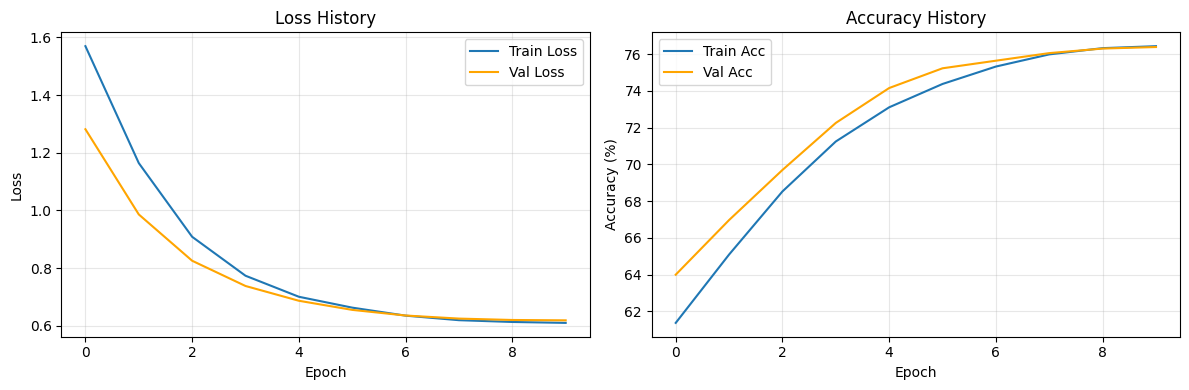

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss 그래프 (train + val)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot([history['val_loss'] for history in training_history], label='Val Loss', color='orange')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy 그래프 (train + val)
plt.subplot(1, 2, 2)
plt.plot([history['train_acc'] for history in training_history], label='Train Acc')
plt.plot(val_accuracies, label='Val Acc', color='orange')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()